In [21]:
import os
import numpy as np
from PIL import Image
import xml.etree.ElementTree as et
import shutil

from numpy import expand_dims
from numpy import zeros
from numpy import ones
from numpy import vstack
from numpy.random import randn
from numpy.random import randint

import tensorflow as tf
from keras.datasets.cifar10 import load_data
from tensorflow.keras.optimizers import Adam
from tensorflow.keras.preprocessing.image import img_to_array, array_to_img
from keras.models import Sequential
from keras.layers import Dense
from keras.layers import Reshape
from keras.layers import Flatten
from keras.layers import Conv2D
from keras.layers import Conv2DTranspose
from keras.layers import LeakyReLU
from keras.layers import Dropout
from keras.layers import BatchNormalization
from matplotlib import pyplot


In [22]:
def read_image(file, bounds):
    image = open_image(file, bounds)
    image = normalize_image(image)
    return image

def open_image(file, bounds):
    image = Image.open(file)
    image = image.crop(bounds)
    image = image.resize((64, 64))
    return np.array(image)

def normalize_image(image):
    image = np.asarray(image, np.float32)
    image = image / 127.5 - 1
    return img_to_array(image)

def denormalize_image(image):
    return ((image+1)*127.5).astype(np.uint8)

def load_images():
    images = []
    for breed in os.listdir('Annotation/'):
        for dog in os.listdir('Annotation/' + breed):
            tree = et.parse('Annotation/' + breed + '/' + dog)
            root = tree.getroot()
            objects = root.findall('object')
            for o in objects:
                box = o.find('bndbox')
                xmin = int(box.find('xmin').text)
                ymin = int(box.find('ymin').text)
                xmax = int(box.find('xmax').text)
                ymax = int(box.find('ymax').text)
            bounds = (xmin, ymin, xmax, ymax)
            try:
                image = read_image('all-dogs/' + dog + '.jpg', bounds)
                images.append(image)
            except:
                print('No image', dog)
    return np.array(images)

In [23]:
def define_discriminator(in_shape=(64,64,3)):
    model = Sequential()
    model.add(Conv2D(64, (3,3), padding='same', input_shape=in_shape))
    model.add(LeakyReLU(alpha=0.2))
    model.add(Conv2D(128, (3,3), strides=(2,2), padding='same'))
    model.add(LeakyReLU(alpha=0.2))
    model.add(Conv2D(128, (3,3), strides=(2,2), padding='same'))
    model.add(LeakyReLU(alpha=0.2))
    model.add(Conv2D(256, (3,3), strides=(2,2), padding='same'))
    model.add(LeakyReLU(alpha=0.2))
    model.add(Flatten())
    model.add(Dropout(0.4))
    model.add(Dense(1, activation='sigmoid'))
    opt = Adam(lr=0.0002, beta_1=0.5)
    model.compile(loss='binary_crossentropy', optimizer=opt, metrics=['accuracy'])
    model.summary()
    return model

In [24]:
def define_generator(latent_dim):
    model = Sequential()
    n_nodes = 256 * 8 * 8
    model.add(Dense(n_nodes, input_dim=latent_dim))
    model.add(LeakyReLU(alpha=0.2))
    model.add(Reshape((8, 8, 256)))
    model.add(Conv2DTranspose(128, (4,4), strides=(2,2), padding='same'))
    model.add(LeakyReLU(alpha=0.2))
    model.add(Conv2DTranspose(128, (4,4), strides=(2,2), padding='same'))
    model.add(LeakyReLU(alpha=0.2))
    model.add(Conv2DTranspose(128, (4,4), strides=(2,2), padding='same'))
    model.add(LeakyReLU(alpha=0.2))
    model.add(Conv2D(3, (3,3), activation='tanh', padding='same'))
    model.summary()
    return model

In [25]:
def define_gan(g_model, d_model):
    d_model.trainable = False
    model = Sequential()
    model.add(g_model)
    model.add(d_model)
    opt = Adam(lr=0.0002, beta_1=0.5)
    model.compile(loss='binary_crossentropy', optimizer=opt)
    model.summary()
    return model

In [26]:
def generate_real_samples(dataset, n_samples):
    ix = randint(0, dataset.shape[0], n_samples)
    X = dataset[ix]
    y = ones((n_samples, 1))
    return X, y

def generate_latent_points(latent_dim, n_samples):
    x_input = randn(latent_dim * n_samples)
    x_input = x_input.reshape(n_samples, latent_dim)
    return x_input

def generate_fake_samples(g_model, latent_dim, n_samples):
    x_input = generate_latent_points(latent_dim, n_samples)
    X = g_model.predict(x_input)
    y = zeros((n_samples, 1))
    return X, y

def save_plot(examples, epoch, n=7):
    examples = (examples + 1) / 2.0
    for i in range(n * n):
        pyplot.subplot(n, n, 1 + i)
        pyplot.axis('off')
        pyplot.imshow(examples[i])
    pyplot.show()

In [27]:
def summarize_performance(epoch, g_model, d_model, dataset, latent_dim, n_samples=150):
    X_real, y_real = generate_real_samples(dataset, n_samples)
    _, acc_real = d_model.evaluate(X_real, y_real, verbose=0)
    x_fake, y_fake = generate_fake_samples(g_model, latent_dim, n_samples)
    _, acc_fake = d_model.evaluate(x_fake, y_fake, verbose=0)
    print('>Accuracy real: %.0f%%, fake: %.0f%%' % (acc_real*100, acc_fake*100))
    save_plot(x_fake, epoch)

In [28]:
def train(g_model, d_model, gan_model, dataset, latent_dim, n_epochs=500, n_batch=128):
    bat_per_epo = int(dataset.shape[0] / n_batch)
    half_batch = int(n_batch / 2)
    for i in range(n_epochs):
        for j in range(bat_per_epo):
            X_real, y_real = generate_real_samples(dataset, half_batch)
            d_loss1, _ = d_model.train_on_batch(X_real, y_real)
            X_fake, y_fake = generate_fake_samples(g_model, latent_dim, half_batch)
            d_loss2, _ = d_model.train_on_batch(X_fake, y_fake)
            X_gan = generate_latent_points(latent_dim, n_batch)
            y_gan = ones((n_batch, 1))
            g_loss = gan_model.train_on_batch(X_gan, y_gan)
            print('>%d, %d/%d, d1=%.3f, d2=%.3f g=%.3f' %
                (i+1, j+1, bat_per_epo, d_loss1, d_loss2, g_loss))
        if (i+1) % 1 == 0:
            summarize_performance(i, g_model, d_model, dataset, latent_dim)

Model: "sequential_6"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
conv2d_10 (Conv2D)           (None, 64, 64, 64)        1792      
_________________________________________________________________
leaky_re_lu_16 (LeakyReLU)   (None, 64, 64, 64)        0         
_________________________________________________________________
conv2d_11 (Conv2D)           (None, 32, 32, 128)       73856     
_________________________________________________________________
leaky_re_lu_17 (LeakyReLU)   (None, 32, 32, 128)       0         
_________________________________________________________________
conv2d_12 (Conv2D)           (None, 16, 16, 128)       147584    
_________________________________________________________________
leaky_re_lu_18 (LeakyReLU)   (None, 16, 16, 128)       0         
_________________________________________________________________
conv2d_13 (Conv2D)           (None, 8, 8, 256)        

>1, 105/160, d1=0.143, d2=0.075 g=2.960
>1, 106/160, d1=0.150, d2=0.071 g=3.060
>1, 107/160, d1=0.092, d2=0.062 g=3.162
>1, 108/160, d1=0.011, d2=0.056 g=3.418
>1, 109/160, d1=0.261, d2=0.069 g=2.991
>1, 110/160, d1=0.125, d2=0.108 g=3.008
>1, 111/160, d1=0.131, d2=0.086 g=3.104
>1, 112/160, d1=0.321, d2=0.143 g=3.216
>1, 113/160, d1=0.080, d2=0.059 g=3.487
>1, 114/160, d1=0.185, d2=0.095 g=3.547
>1, 115/160, d1=0.192, d2=0.118 g=3.956
>1, 116/160, d1=0.165, d2=0.070 g=4.167
>1, 117/160, d1=0.164, d2=0.127 g=5.011
>1, 118/160, d1=0.034, d2=0.009 g=5.426
>1, 119/160, d1=0.080, d2=0.034 g=4.856
>1, 120/160, d1=0.096, d2=1.254 g=10.761
>1, 121/160, d1=0.195, d2=0.000 g=12.708
>1, 122/160, d1=0.780, d2=0.001 g=7.588
>1, 123/160, d1=0.761, d2=1.064 g=5.896
>1, 124/160, d1=0.610, d2=0.509 g=6.500
>1, 125/160, d1=0.942, d2=0.029 g=4.628
>1, 126/160, d1=0.371, d2=0.643 g=5.025
>1, 127/160, d1=0.843, d2=0.066 g=3.802
>1, 128/160, d1=0.297, d2=1.185 g=4.421
>1, 129/160, d1=0.586, d2=0.096 g=3.74

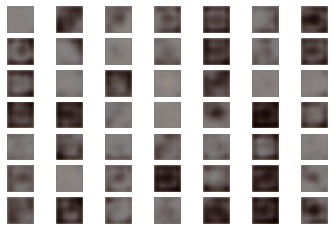

>2, 1/160, d1=0.180, d2=0.170 g=2.297
>2, 2/160, d1=0.265, d2=0.161 g=2.254
>2, 3/160, d1=0.072, d2=0.125 g=2.570
>2, 4/160, d1=0.164, d2=0.095 g=2.683
>2, 5/160, d1=0.403, d2=0.131 g=2.362
>2, 6/160, d1=0.100, d2=0.117 g=2.544
>2, 7/160, d1=0.269, d2=0.182 g=2.300
>2, 8/160, d1=0.042, d2=0.126 g=2.674
>2, 9/160, d1=0.233, d2=0.088 g=2.565
>2, 10/160, d1=0.153, d2=0.152 g=2.623
>2, 11/160, d1=0.207, d2=0.135 g=2.469
>2, 12/160, d1=0.180, d2=0.146 g=2.475
>2, 13/160, d1=0.238, d2=0.170 g=2.466
>2, 14/160, d1=0.158, d2=0.110 g=2.518
>2, 15/160, d1=0.310, d2=0.324 g=2.140
>2, 16/160, d1=0.355, d2=0.556 g=1.958
>2, 17/160, d1=0.176, d2=0.563 g=2.352
>2, 18/160, d1=0.333, d2=0.889 g=2.048
>2, 19/160, d1=0.180, d2=0.455 g=2.043
>2, 20/160, d1=0.128, d2=0.818 g=1.942
>2, 21/160, d1=0.272, d2=0.954 g=2.021
>2, 22/160, d1=0.348, d2=0.745 g=1.807
>2, 23/160, d1=0.496, d2=0.607 g=2.099
>2, 24/160, d1=0.457, d2=0.698 g=1.807
>2, 25/160, d1=0.565, d2=0.787 g=1.462
>2, 26/160, d1=0.458, d2=0.823 g=1

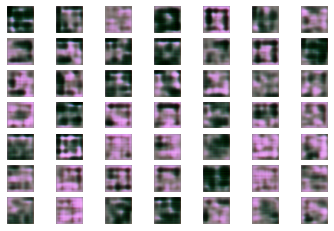

>3, 1/160, d1=0.301, d2=0.441 g=1.712
>3, 2/160, d1=0.238, d2=0.354 g=1.683
>3, 3/160, d1=0.350, d2=0.394 g=1.619
>3, 4/160, d1=0.211, d2=0.447 g=1.676
>3, 5/160, d1=0.297, d2=0.411 g=1.517
>3, 6/160, d1=0.408, d2=0.648 g=1.501
>3, 7/160, d1=0.453, d2=0.586 g=1.624
>3, 8/160, d1=0.382, d2=0.477 g=1.754
>3, 9/160, d1=0.350, d2=0.372 g=1.978
>3, 10/160, d1=0.259, d2=0.292 g=2.154
>3, 11/160, d1=0.233, d2=0.222 g=2.344
>3, 12/160, d1=0.310, d2=0.314 g=2.648
>3, 13/160, d1=0.275, d2=0.195 g=2.666
>3, 14/160, d1=0.201, d2=0.336 g=3.213
>3, 15/160, d1=0.241, d2=0.218 g=3.573
>3, 16/160, d1=0.468, d2=0.397 g=3.840
>3, 17/160, d1=0.590, d2=0.241 g=3.248
>3, 18/160, d1=0.377, d2=0.414 g=3.413
>3, 19/160, d1=0.381, d2=0.111 g=3.122
>3, 20/160, d1=0.243, d2=0.256 g=3.514
>3, 21/160, d1=0.099, d2=0.082 g=3.776
>3, 22/160, d1=0.116, d2=0.139 g=3.523
>3, 23/160, d1=0.251, d2=0.425 g=3.619
>3, 24/160, d1=0.130, d2=0.142 g=3.792
>3, 25/160, d1=0.161, d2=0.126 g=3.134
>3, 26/160, d1=0.155, d2=0.624 g=3

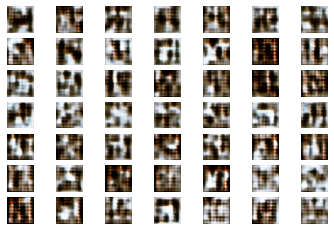

>4, 1/160, d1=0.512, d2=0.486 g=1.363
>4, 2/160, d1=0.660, d2=0.497 g=1.236
>4, 3/160, d1=0.713, d2=0.526 g=1.278
>4, 4/160, d1=0.639, d2=0.509 g=1.273
>4, 5/160, d1=0.684, d2=0.508 g=1.285
>4, 6/160, d1=0.720, d2=0.588 g=1.250
>4, 7/160, d1=0.636, d2=0.517 g=1.248
>4, 8/160, d1=0.730, d2=0.547 g=1.188
>4, 9/160, d1=0.695, d2=0.537 g=1.202
>4, 10/160, d1=0.730, d2=0.495 g=1.281
>4, 11/160, d1=0.766, d2=0.614 g=1.206
>4, 12/160, d1=0.669, d2=0.625 g=1.254
>4, 13/160, d1=0.625, d2=0.579 g=1.308
>4, 14/160, d1=0.730, d2=0.472 g=1.334
>4, 15/160, d1=0.604, d2=0.547 g=1.267
>4, 16/160, d1=0.629, d2=0.606 g=1.183
>4, 17/160, d1=0.707, d2=0.641 g=1.070
>4, 18/160, d1=0.527, d2=0.558 g=1.157
>4, 19/160, d1=0.587, d2=0.530 g=1.149
>4, 20/160, d1=0.557, d2=0.588 g=1.162
>4, 21/160, d1=0.605, d2=0.596 g=1.240
>4, 22/160, d1=0.488, d2=0.554 g=1.264
>4, 23/160, d1=0.469, d2=0.579 g=1.251
>4, 24/160, d1=0.456, d2=0.618 g=1.387
>4, 25/160, d1=0.471, d2=0.467 g=1.430
>4, 26/160, d1=0.602, d2=0.648 g=1

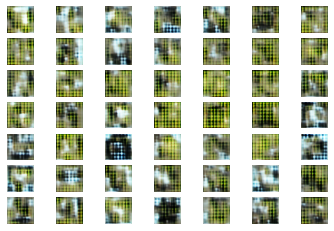

>5, 1/160, d1=0.509, d2=0.516 g=1.485
>5, 2/160, d1=0.612, d2=0.525 g=1.373
>5, 3/160, d1=0.593, d2=0.522 g=1.368
>5, 4/160, d1=0.592, d2=0.515 g=1.177
>5, 5/160, d1=0.554, d2=0.596 g=1.195
>5, 6/160, d1=0.596, d2=0.719 g=1.193
>5, 7/160, d1=0.621, d2=0.689 g=1.098
>5, 8/160, d1=0.686, d2=0.719 g=1.108
>5, 9/160, d1=0.710, d2=0.714 g=1.012
>5, 10/160, d1=0.620, d2=0.621 g=1.105
>5, 11/160, d1=0.642, d2=0.614 g=1.075
>5, 12/160, d1=0.710, d2=0.625 g=1.022
>5, 13/160, d1=0.643, d2=0.658 g=1.071
>5, 14/160, d1=0.642, d2=0.630 g=1.098
>5, 15/160, d1=0.789, d2=0.585 g=1.032
>5, 16/160, d1=0.730, d2=0.667 g=0.963
>5, 17/160, d1=0.694, d2=0.635 g=0.930
>5, 18/160, d1=0.659, d2=0.733 g=0.974
>5, 19/160, d1=0.649, d2=0.617 g=0.991
>5, 20/160, d1=0.695, d2=0.612 g=0.955
>5, 21/160, d1=0.665, d2=0.591 g=0.914
>5, 22/160, d1=0.629, d2=0.591 g=0.952
>5, 23/160, d1=0.656, d2=0.639 g=0.946
>5, 24/160, d1=0.623, d2=0.587 g=0.982
>5, 25/160, d1=0.663, d2=0.586 g=1.003
>5, 26/160, d1=0.653, d2=0.591 g=1

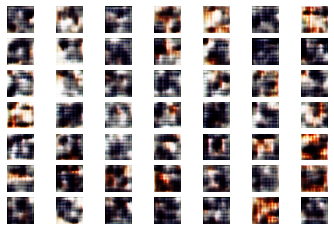

>6, 1/160, d1=0.468, d2=0.527 g=1.442
>6, 2/160, d1=0.640, d2=0.557 g=1.455
>6, 3/160, d1=0.688, d2=0.592 g=1.442
>6, 4/160, d1=0.780, d2=0.601 g=1.223
>6, 5/160, d1=0.711, d2=0.674 g=1.133
>6, 6/160, d1=0.739, d2=0.670 g=1.118
>6, 7/160, d1=0.852, d2=0.788 g=1.034
>6, 8/160, d1=0.862, d2=0.793 g=1.018
>6, 9/160, d1=0.880, d2=0.668 g=1.046
>6, 10/160, d1=0.951, d2=0.704 g=0.960
>6, 11/160, d1=0.763, d2=0.688 g=0.999
>6, 12/160, d1=0.776, d2=0.601 g=1.120
>6, 13/160, d1=0.766, d2=0.503 g=1.215
>6, 14/160, d1=0.773, d2=0.489 g=1.274
>6, 15/160, d1=0.725, d2=0.448 g=1.270
>6, 16/160, d1=0.671, d2=0.473 g=1.268
>6, 17/160, d1=0.650, d2=0.482 g=1.323
>6, 18/160, d1=0.631, d2=0.463 g=1.229
>6, 19/160, d1=0.576, d2=0.489 g=1.132
>6, 20/160, d1=0.550, d2=0.533 g=1.123
>6, 21/160, d1=0.556, d2=0.589 g=1.214
>6, 22/160, d1=0.597, d2=0.478 g=1.203
>6, 23/160, d1=0.594, d2=0.559 g=1.051
>6, 24/160, d1=0.643, d2=0.654 g=1.028
>6, 25/160, d1=0.600, d2=0.585 g=1.077
>6, 26/160, d1=0.608, d2=0.528 g=1

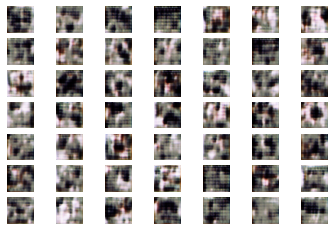

>7, 1/160, d1=0.397, d2=0.495 g=1.221
>7, 2/160, d1=0.450, d2=0.487 g=1.261
>7, 3/160, d1=0.399, d2=0.489 g=1.281
>7, 4/160, d1=0.464, d2=0.521 g=1.247
>7, 5/160, d1=0.490, d2=0.622 g=1.260
>7, 6/160, d1=0.563, d2=0.575 g=1.256
>7, 7/160, d1=0.633, d2=0.614 g=1.248
>7, 8/160, d1=0.551, d2=0.550 g=1.297
>7, 9/160, d1=0.586, d2=0.465 g=1.345
>7, 10/160, d1=0.598, d2=0.523 g=1.373
>7, 11/160, d1=0.482, d2=0.478 g=1.394
>7, 12/160, d1=0.440, d2=0.403 g=1.435
>7, 13/160, d1=0.426, d2=0.448 g=1.375
>7, 14/160, d1=0.468, d2=0.488 g=1.275
>7, 15/160, d1=0.494, d2=0.648 g=1.179
>7, 16/160, d1=0.391, d2=0.694 g=1.269
>7, 17/160, d1=0.471, d2=0.630 g=1.258
>7, 18/160, d1=0.584, d2=0.603 g=1.233
>7, 19/160, d1=0.534, d2=0.610 g=1.283
>7, 20/160, d1=0.587, d2=0.620 g=1.394
>7, 21/160, d1=0.570, d2=0.514 g=1.585
>7, 22/160, d1=0.656, d2=0.396 g=1.658
>7, 23/160, d1=0.568, d2=0.602 g=1.911
>7, 24/160, d1=0.598, d2=0.295 g=1.940
>7, 25/160, d1=0.523, d2=0.521 g=2.040
>7, 26/160, d1=0.761, d2=0.478 g=1

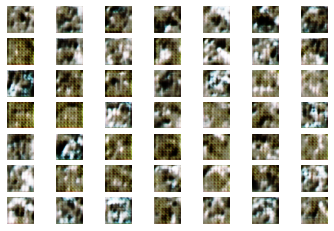

>8, 1/160, d1=0.570, d2=0.715 g=1.065
>8, 2/160, d1=0.571, d2=0.657 g=1.112
>8, 3/160, d1=0.645, d2=0.680 g=1.081
>8, 4/160, d1=0.742, d2=0.722 g=1.062
>8, 5/160, d1=0.679, d2=0.750 g=1.031
>8, 6/160, d1=0.697, d2=0.711 g=1.039
>8, 7/160, d1=0.730, d2=0.750 g=1.107
>8, 8/160, d1=0.679, d2=0.640 g=1.175
>8, 9/160, d1=0.662, d2=0.616 g=1.023
>8, 10/160, d1=0.568, d2=0.616 g=1.181
>8, 11/160, d1=0.673, d2=0.601 g=1.214
>8, 12/160, d1=0.604, d2=0.643 g=1.233
>8, 13/160, d1=0.630, d2=0.668 g=1.216
>8, 14/160, d1=0.688, d2=0.691 g=1.100
>8, 15/160, d1=0.617, d2=0.662 g=1.110
>8, 16/160, d1=0.696, d2=0.594 g=1.044
>8, 17/160, d1=0.668, d2=0.630 g=1.034
>8, 18/160, d1=0.618, d2=0.640 g=1.072
>8, 19/160, d1=0.639, d2=0.613 g=1.108
>8, 20/160, d1=0.610, d2=0.569 g=1.160
>8, 21/160, d1=0.688, d2=0.587 g=1.257
>8, 22/160, d1=0.681, d2=0.492 g=1.380
>8, 23/160, d1=0.704, d2=0.463 g=1.419
>8, 24/160, d1=0.693, d2=0.449 g=1.582
>8, 25/160, d1=0.627, d2=0.390 g=1.744
>8, 26/160, d1=0.647, d2=0.343 g=1

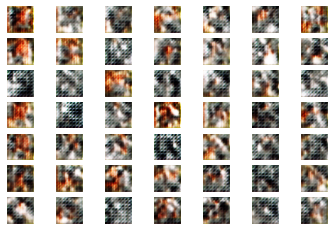

>9, 1/160, d1=0.490, d2=0.516 g=1.289
>9, 2/160, d1=0.541, d2=0.533 g=1.360
>9, 3/160, d1=0.517, d2=0.456 g=1.407
>9, 4/160, d1=0.546, d2=0.477 g=1.380
>9, 5/160, d1=0.508, d2=0.486 g=1.431
>9, 6/160, d1=0.443, d2=0.517 g=1.345
>9, 7/160, d1=0.501, d2=0.514 g=1.356
>9, 8/160, d1=0.508, d2=0.491 g=1.379
>9, 9/160, d1=0.467, d2=0.652 g=1.512
>9, 10/160, d1=0.507, d2=0.479 g=1.612
>9, 11/160, d1=0.704, d2=0.422 g=1.650
>9, 12/160, d1=0.572, d2=0.485 g=1.534
>9, 13/160, d1=0.542, d2=0.452 g=1.603
>9, 14/160, d1=0.521, d2=0.560 g=1.445
>9, 15/160, d1=0.470, d2=0.532 g=1.358
>9, 16/160, d1=0.430, d2=0.549 g=1.341
>9, 17/160, d1=0.492, d2=0.518 g=1.271
>9, 18/160, d1=0.471, d2=0.591 g=1.192
>9, 19/160, d1=0.501, d2=0.619 g=1.102
>9, 20/160, d1=0.391, d2=0.589 g=1.093
>9, 21/160, d1=0.421, d2=0.634 g=1.087
>9, 22/160, d1=0.573, d2=0.692 g=1.055
>9, 23/160, d1=0.484, d2=0.718 g=1.178
>9, 24/160, d1=0.647, d2=0.629 g=1.187
>9, 25/160, d1=0.560, d2=0.642 g=1.225
>9, 26/160, d1=0.524, d2=0.534 g=1

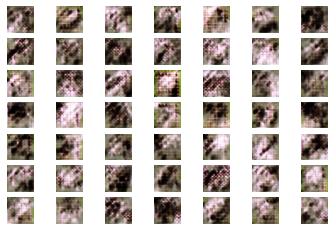

>10, 1/160, d1=0.483, d2=0.505 g=1.588
>10, 2/160, d1=0.606, d2=0.666 g=1.474
>10, 3/160, d1=0.667, d2=0.743 g=1.535
>10, 4/160, d1=0.799, d2=0.653 g=1.674
>10, 5/160, d1=0.772, d2=0.497 g=1.755
>10, 6/160, d1=0.771, d2=0.548 g=1.706
>10, 7/160, d1=0.633, d2=0.479 g=1.977
>10, 8/160, d1=0.683, d2=0.406 g=1.787
>10, 9/160, d1=0.584, d2=0.377 g=1.906
>10, 10/160, d1=0.513, d2=0.375 g=1.820
>10, 11/160, d1=0.533, d2=0.465 g=1.776
>10, 12/160, d1=0.597, d2=0.436 g=1.694
>10, 13/160, d1=0.480, d2=0.521 g=1.688
>10, 14/160, d1=0.580, d2=0.552 g=1.576
>10, 15/160, d1=0.511, d2=0.534 g=1.521
>10, 16/160, d1=0.598, d2=0.612 g=1.264
>10, 17/160, d1=0.538, d2=0.640 g=1.246
>10, 18/160, d1=0.562, d2=0.687 g=1.305
>10, 19/160, d1=0.526, d2=0.559 g=1.309
>10, 20/160, d1=0.749, d2=0.599 g=1.255
>10, 21/160, d1=0.560, d2=0.696 g=1.341
>10, 22/160, d1=0.538, d2=0.519 g=1.469
>10, 23/160, d1=0.790, d2=0.434 g=1.433
>10, 24/160, d1=0.599, d2=0.469 g=1.505
>10, 25/160, d1=0.469, d2=0.513 g=1.614
>10, 26/1

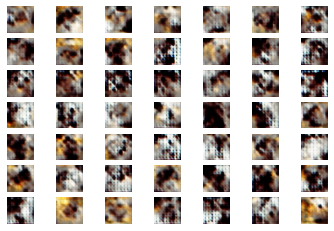

>11, 1/160, d1=0.525, d2=0.484 g=1.465
>11, 2/160, d1=0.479, d2=0.516 g=1.518
>11, 3/160, d1=0.633, d2=0.511 g=1.433
>11, 4/160, d1=0.585, d2=0.651 g=1.414
>11, 5/160, d1=0.708, d2=0.596 g=1.418
>11, 6/160, d1=0.734, d2=0.657 g=1.345
>11, 7/160, d1=0.544, d2=0.691 g=1.419
>11, 8/160, d1=0.623, d2=0.604 g=1.374
>11, 9/160, d1=0.430, d2=0.497 g=1.552
>11, 10/160, d1=0.494, d2=0.453 g=1.521
>11, 11/160, d1=0.361, d2=0.460 g=1.526
>11, 12/160, d1=0.405, d2=0.522 g=1.422
>11, 13/160, d1=0.336, d2=0.582 g=1.237
>11, 14/160, d1=0.448, d2=0.619 g=1.182
>11, 15/160, d1=0.288, d2=0.678 g=1.096
>11, 16/160, d1=0.419, d2=0.696 g=1.120
>11, 17/160, d1=0.663, d2=0.669 g=1.111
>11, 18/160, d1=0.662, d2=0.748 g=1.209
>11, 19/160, d1=0.666, d2=0.553 g=1.184
>11, 20/160, d1=0.568, d2=0.569 g=1.153
>11, 21/160, d1=0.553, d2=0.622 g=1.158
>11, 22/160, d1=0.680, d2=0.548 g=1.256
>11, 23/160, d1=0.400, d2=0.475 g=1.409
>11, 24/160, d1=0.414, d2=0.397 g=1.583
>11, 25/160, d1=0.581, d2=0.400 g=1.498
>11, 26/1

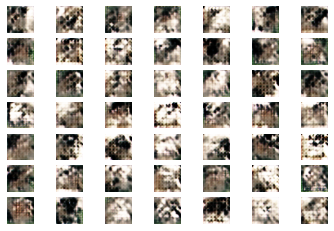

>12, 1/160, d1=0.454, d2=0.512 g=1.892
>12, 2/160, d1=0.595, d2=0.583 g=1.829
>12, 3/160, d1=0.690, d2=0.672 g=1.727
>12, 4/160, d1=0.662, d2=0.548 g=1.605
>12, 5/160, d1=0.604, d2=0.700 g=1.587
>12, 6/160, d1=0.431, d2=0.650 g=1.631
>12, 7/160, d1=0.373, d2=0.690 g=1.616
>12, 8/160, d1=0.646, d2=0.859 g=1.546
>12, 9/160, d1=0.475, d2=0.894 g=1.876
>12, 10/160, d1=0.577, d2=0.712 g=2.122
>12, 11/160, d1=0.799, d2=0.571 g=2.130
>12, 12/160, d1=0.545, d2=0.562 g=2.355
>12, 13/160, d1=0.500, d2=0.395 g=2.350
>12, 14/160, d1=0.483, d2=0.322 g=2.107
>12, 15/160, d1=0.561, d2=0.904 g=2.337
>12, 16/160, d1=0.536, d2=0.361 g=2.305
>12, 17/160, d1=0.553, d2=0.660 g=2.284
>12, 18/160, d1=0.736, d2=0.672 g=2.483
>12, 19/160, d1=0.864, d2=0.368 g=1.892
>12, 20/160, d1=0.543, d2=0.568 g=1.911
>12, 21/160, d1=0.414, d2=0.301 g=1.767
>12, 22/160, d1=0.355, d2=0.390 g=1.869
>12, 23/160, d1=0.309, d2=0.356 g=2.188
>12, 24/160, d1=0.338, d2=0.215 g=2.143
>12, 25/160, d1=0.450, d2=0.350 g=2.129
>12, 26/1

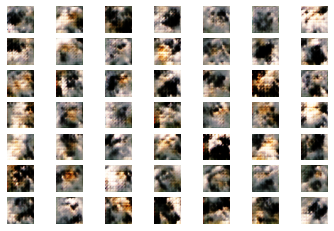

>13, 1/160, d1=0.590, d2=0.635 g=1.495
>13, 2/160, d1=0.840, d2=0.631 g=1.333
>13, 3/160, d1=0.769, d2=0.562 g=1.401
>13, 4/160, d1=0.766, d2=0.586 g=1.423
>13, 5/160, d1=0.651, d2=0.494 g=1.563
>13, 6/160, d1=0.648, d2=0.506 g=1.408
>13, 7/160, d1=0.516, d2=0.418 g=1.571
>13, 8/160, d1=0.558, d2=0.451 g=1.564
>13, 9/160, d1=0.522, d2=0.456 g=1.460
>13, 10/160, d1=0.505, d2=0.504 g=1.520
>13, 11/160, d1=0.532, d2=0.542 g=1.436
>13, 12/160, d1=0.533, d2=0.547 g=1.443
>13, 13/160, d1=0.617, d2=0.634 g=1.296
>13, 14/160, d1=0.698, d2=0.726 g=1.339
>13, 15/160, d1=0.687, d2=0.818 g=1.597
>13, 16/160, d1=0.699, d2=0.486 g=1.528
>13, 17/160, d1=0.753, d2=0.599 g=1.338
>13, 18/160, d1=0.583, d2=0.478 g=1.377
>13, 19/160, d1=0.645, d2=0.591 g=1.396
>13, 20/160, d1=0.475, d2=0.548 g=1.699
>13, 21/160, d1=0.578, d2=0.444 g=1.667
>13, 22/160, d1=0.621, d2=0.441 g=1.541
>13, 23/160, d1=0.591, d2=0.639 g=1.533
>13, 24/160, d1=0.602, d2=0.556 g=1.543
>13, 25/160, d1=0.608, d2=0.530 g=1.515
>13, 26/1

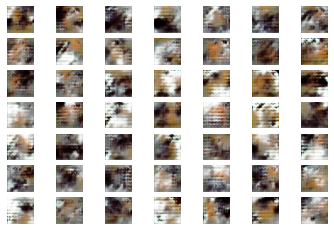

>14, 1/160, d1=0.539, d2=0.599 g=1.175
>14, 2/160, d1=0.510, d2=0.610 g=1.210
>14, 3/160, d1=0.510, d2=0.634 g=1.295
>14, 4/160, d1=0.528, d2=0.549 g=1.265
>14, 5/160, d1=0.477, d2=0.500 g=1.350
>14, 6/160, d1=0.481, d2=0.569 g=1.363
>14, 7/160, d1=0.561, d2=0.553 g=1.385
>14, 8/160, d1=0.397, d2=0.432 g=1.442
>14, 9/160, d1=0.503, d2=0.432 g=1.303
>14, 10/160, d1=0.439, d2=0.534 g=1.417
>14, 11/160, d1=0.389, d2=0.452 g=1.542
>14, 12/160, d1=0.481, d2=0.400 g=1.523
>14, 13/160, d1=0.415, d2=0.390 g=1.400
>14, 14/160, d1=0.345, d2=0.437 g=1.478
>14, 15/160, d1=0.448, d2=0.441 g=1.525
>14, 16/160, d1=0.486, d2=0.437 g=1.556
>14, 17/160, d1=0.387, d2=0.429 g=1.613
>14, 18/160, d1=0.460, d2=0.421 g=1.587
>14, 19/160, d1=0.361, d2=0.396 g=1.574
>14, 20/160, d1=0.404, d2=0.384 g=1.592
>14, 21/160, d1=0.468, d2=0.427 g=1.560
>14, 22/160, d1=0.363, d2=0.434 g=1.586
>14, 23/160, d1=0.390, d2=0.435 g=1.578
>14, 24/160, d1=0.391, d2=0.419 g=1.612
>14, 25/160, d1=0.501, d2=0.413 g=1.570
>14, 26/1

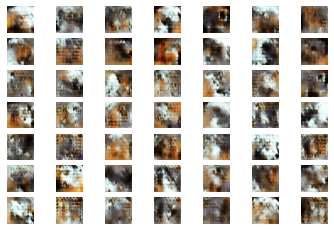

>15, 1/160, d1=0.403, d2=0.425 g=1.421
>15, 2/160, d1=0.665, d2=0.508 g=1.471
>15, 3/160, d1=0.548, d2=0.582 g=1.498
>15, 4/160, d1=0.496, d2=0.436 g=1.503
>15, 5/160, d1=0.418, d2=0.448 g=1.616
>15, 6/160, d1=0.482, d2=0.420 g=1.643
>15, 7/160, d1=0.507, d2=0.402 g=1.513
>15, 8/160, d1=0.438, d2=0.427 g=1.503
>15, 9/160, d1=0.410, d2=0.511 g=1.722
>15, 10/160, d1=0.509, d2=0.409 g=1.761
>15, 11/160, d1=0.680, d2=0.499 g=1.450
>15, 12/160, d1=0.495, d2=0.664 g=1.717
>15, 13/160, d1=0.622, d2=0.621 g=1.847
>15, 14/160, d1=0.816, d2=0.552 g=1.602
>15, 15/160, d1=0.538, d2=0.674 g=1.786
>15, 16/160, d1=0.577, d2=0.598 g=1.917
>15, 17/160, d1=0.743, d2=0.602 g=1.750
>15, 18/160, d1=0.649, d2=0.568 g=1.783
>15, 19/160, d1=0.854, d2=0.642 g=1.588
>15, 20/160, d1=0.648, d2=0.671 g=1.937
>15, 21/160, d1=0.803, d2=0.482 g=1.760
>15, 22/160, d1=0.728, d2=0.645 g=1.782
>15, 23/160, d1=0.648, d2=0.538 g=1.850
>15, 24/160, d1=0.998, d2=0.862 g=1.936
>15, 25/160, d1=0.942, d2=0.510 g=1.745
>15, 26/1

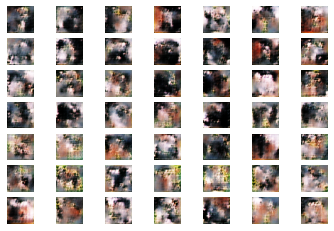

>16, 1/160, d1=0.538, d2=0.579 g=1.381
>16, 2/160, d1=0.643, d2=0.516 g=1.430
>16, 3/160, d1=0.596, d2=0.560 g=1.478
>16, 4/160, d1=0.605, d2=0.531 g=1.580
>16, 5/160, d1=0.789, d2=0.513 g=1.463
>16, 6/160, d1=0.652, d2=0.563 g=1.493
>16, 7/160, d1=0.585, d2=0.516 g=1.607
>16, 8/160, d1=0.753, d2=0.490 g=1.588
>16, 9/160, d1=0.834, d2=0.603 g=1.464
>16, 10/160, d1=0.598, d2=0.497 g=1.427
>16, 11/160, d1=0.585, d2=0.648 g=1.634
>16, 12/160, d1=0.799, d2=0.572 g=1.511
>16, 13/160, d1=0.628, d2=0.527 g=1.449
>16, 14/160, d1=0.553, d2=0.536 g=1.479
>16, 15/160, d1=0.589, d2=0.600 g=1.687
>16, 16/160, d1=0.585, d2=0.519 g=1.774
>16, 17/160, d1=0.722, d2=0.487 g=1.719
>16, 18/160, d1=0.566, d2=0.389 g=1.555
>16, 19/160, d1=0.489, d2=0.613 g=1.706
>16, 20/160, d1=0.545, d2=0.363 g=1.685
>16, 21/160, d1=0.648, d2=0.523 g=1.619
>16, 22/160, d1=0.640, d2=0.524 g=1.692
>16, 23/160, d1=0.610, d2=0.464 g=1.602
>16, 24/160, d1=0.623, d2=0.576 g=1.447
>16, 25/160, d1=0.721, d2=0.633 g=1.456
>16, 26/1

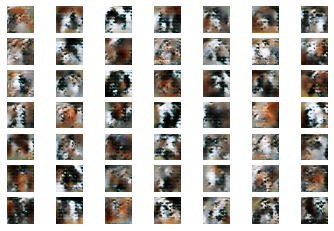

>17, 1/160, d1=0.517, d2=0.474 g=1.382
>17, 2/160, d1=0.554, d2=0.669 g=1.345
>17, 3/160, d1=0.609, d2=0.624 g=1.304
>17, 4/160, d1=0.798, d2=0.627 g=1.221
>17, 5/160, d1=0.680, d2=0.717 g=1.162
>17, 6/160, d1=0.667, d2=0.652 g=1.168
>17, 7/160, d1=0.804, d2=0.615 g=1.134
>17, 8/160, d1=0.671, d2=0.604 g=1.064
>17, 9/160, d1=0.609, d2=0.656 g=1.108
>17, 10/160, d1=0.713, d2=0.638 g=1.055
>17, 11/160, d1=0.551, d2=0.657 g=1.105
>17, 12/160, d1=0.650, d2=0.582 g=1.122
>17, 13/160, d1=0.768, d2=0.634 g=1.118
>17, 14/160, d1=0.656, d2=0.663 g=1.248
>17, 15/160, d1=0.513, d2=0.434 g=1.394
>17, 16/160, d1=0.561, d2=0.494 g=1.369
>17, 17/160, d1=0.716, d2=0.540 g=1.322
>17, 18/160, d1=0.573, d2=0.616 g=1.341
>17, 19/160, d1=0.610, d2=0.575 g=1.445
>17, 20/160, d1=0.710, d2=0.640 g=1.552
>17, 21/160, d1=0.714, d2=0.521 g=1.619
>17, 22/160, d1=0.696, d2=0.421 g=1.731
>17, 23/160, d1=0.830, d2=0.416 g=1.659
>17, 24/160, d1=0.628, d2=0.385 g=1.664
>17, 25/160, d1=0.547, d2=0.396 g=1.632
>17, 26/1

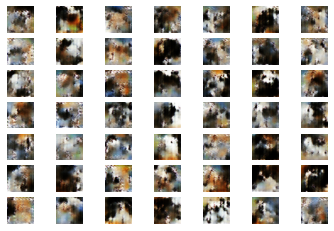

>18, 1/160, d1=0.495, d2=0.486 g=1.257
>18, 2/160, d1=0.635, d2=0.548 g=1.201
>18, 3/160, d1=0.511, d2=0.552 g=1.267
>18, 4/160, d1=0.490, d2=0.531 g=1.371
>18, 5/160, d1=0.634, d2=0.509 g=1.355
>18, 6/160, d1=0.471, d2=0.505 g=1.355
>18, 7/160, d1=0.576, d2=0.505 g=1.313
>18, 8/160, d1=0.438, d2=0.482 g=1.392
>18, 9/160, d1=0.589, d2=0.472 g=1.247
>18, 10/160, d1=0.502, d2=0.542 g=1.386
>18, 11/160, d1=0.493, d2=0.518 g=1.427
>18, 12/160, d1=0.776, d2=0.591 g=1.238
>18, 13/160, d1=0.594, d2=0.631 g=1.327
>18, 14/160, d1=0.748, d2=0.510 g=1.221
>18, 15/160, d1=0.631, d2=0.664 g=1.356
>18, 16/160, d1=0.584, d2=0.523 g=1.379
>18, 17/160, d1=0.623, d2=0.655 g=1.368
>18, 18/160, d1=0.559, d2=0.589 g=1.311
>18, 19/160, d1=0.584, d2=0.583 g=1.375
>18, 20/160, d1=0.696, d2=0.695 g=1.474
>18, 21/160, d1=0.722, d2=0.504 g=1.380
>18, 22/160, d1=0.688, d2=0.504 g=1.421
>18, 23/160, d1=0.586, d2=0.517 g=1.481
>18, 24/160, d1=0.651, d2=0.455 g=1.404
>18, 25/160, d1=0.627, d2=0.522 g=1.427
>18, 26/1

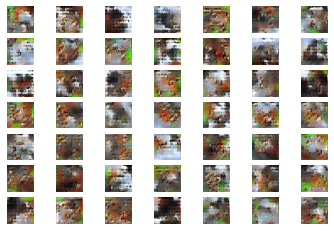

>19, 1/160, d1=0.415, d2=0.455 g=1.560
>19, 2/160, d1=0.480, d2=0.405 g=1.596
>19, 3/160, d1=0.442, d2=0.436 g=1.552
>19, 4/160, d1=0.492, d2=0.489 g=1.352
>19, 5/160, d1=0.562, d2=0.611 g=1.294
>19, 6/160, d1=0.571, d2=0.763 g=1.139
>19, 7/160, d1=0.660, d2=0.681 g=1.212
>19, 8/160, d1=0.607, d2=0.637 g=1.263
>19, 9/160, d1=0.796, d2=0.642 g=1.251
>19, 10/160, d1=0.815, d2=0.649 g=1.299
>19, 11/160, d1=0.848, d2=0.541 g=1.299
>19, 12/160, d1=0.601, d2=0.569 g=1.518
>19, 13/160, d1=0.571, d2=0.411 g=1.635
>19, 14/160, d1=0.680, d2=0.433 g=1.404
>19, 15/160, d1=0.499, d2=0.535 g=1.394
>19, 16/160, d1=0.468, d2=0.506 g=1.308
>19, 17/160, d1=0.412, d2=0.580 g=1.269
>19, 18/160, d1=0.508, d2=0.547 g=1.163
>19, 19/160, d1=0.511, d2=0.581 g=1.156
>19, 20/160, d1=0.481, d2=0.606 g=1.159
>19, 21/160, d1=0.622, d2=0.649 g=1.141
>19, 22/160, d1=0.527, d2=0.575 g=1.180
>19, 23/160, d1=0.603, d2=0.646 g=1.161
>19, 24/160, d1=0.636, d2=0.628 g=1.114
>19, 25/160, d1=0.704, d2=0.688 g=1.171
>19, 26/1

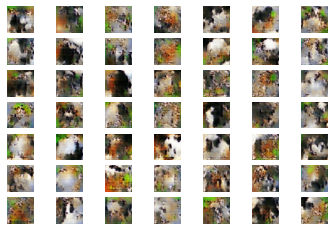

>20, 1/160, d1=0.562, d2=0.619 g=1.225
>20, 2/160, d1=0.670, d2=0.655 g=1.203
>20, 3/160, d1=0.802, d2=0.709 g=1.108
>20, 4/160, d1=0.653, d2=0.711 g=1.120
>20, 5/160, d1=0.727, d2=0.621 g=1.164
>20, 6/160, d1=0.728, d2=0.629 g=1.115
>20, 7/160, d1=0.829, d2=0.686 g=1.073
>20, 8/160, d1=0.680, d2=0.627 g=1.080
>20, 9/160, d1=0.679, d2=0.636 g=1.216
>20, 10/160, d1=0.615, d2=0.539 g=1.204
>20, 11/160, d1=0.621, d2=0.582 g=1.264
>20, 12/160, d1=0.639, d2=0.545 g=1.231
>20, 13/160, d1=0.572, d2=0.481 g=1.252
>20, 14/160, d1=0.582, d2=0.518 g=1.194
>20, 15/160, d1=0.554, d2=0.513 g=1.214
>20, 16/160, d1=0.514, d2=0.492 g=1.170
>20, 17/160, d1=0.548, d2=0.553 g=1.185
>20, 18/160, d1=0.503, d2=0.556 g=1.153
>20, 19/160, d1=0.511, d2=0.561 g=1.186
>20, 20/160, d1=0.453, d2=0.611 g=1.233
>20, 21/160, d1=0.488, d2=0.652 g=1.220
>20, 22/160, d1=0.634, d2=0.575 g=1.246
>20, 23/160, d1=0.631, d2=0.673 g=1.101
>20, 24/160, d1=0.721, d2=0.622 g=1.147
>20, 25/160, d1=0.553, d2=0.631 g=1.192
>20, 26/1

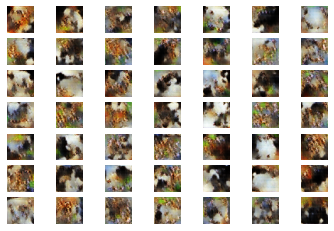

>21, 1/160, d1=0.520, d2=0.591 g=1.205
>21, 2/160, d1=0.589, d2=0.601 g=1.182
>21, 3/160, d1=0.609, d2=0.657 g=1.297
>21, 4/160, d1=0.689, d2=0.654 g=1.330
>21, 5/160, d1=0.702, d2=0.476 g=1.242
>21, 6/160, d1=0.587, d2=0.549 g=1.302
>21, 7/160, d1=0.563, d2=0.617 g=1.227
>21, 8/160, d1=0.612, d2=0.537 g=1.274
>21, 9/160, d1=0.606, d2=0.536 g=1.252
>21, 10/160, d1=0.610, d2=0.594 g=1.250
>21, 11/160, d1=0.570, d2=0.608 g=1.339
>21, 12/160, d1=0.593, d2=0.506 g=1.349
>21, 13/160, d1=0.588, d2=0.582 g=1.310
>21, 14/160, d1=0.551, d2=0.537 g=1.220
>21, 15/160, d1=0.670, d2=0.710 g=1.302
>21, 16/160, d1=0.763, d2=0.574 g=1.243
>21, 17/160, d1=0.701, d2=0.790 g=1.311
>21, 18/160, d1=0.720, d2=0.654 g=1.358
>21, 19/160, d1=0.825, d2=0.711 g=1.337
>21, 20/160, d1=0.801, d2=0.591 g=1.347
>21, 21/160, d1=0.839, d2=0.670 g=1.263
>21, 22/160, d1=0.911, d2=0.737 g=1.339
>21, 23/160, d1=0.829, d2=0.534 g=1.327
>21, 24/160, d1=0.837, d2=0.488 g=1.204
>21, 25/160, d1=0.637, d2=0.564 g=1.223
>21, 26/1

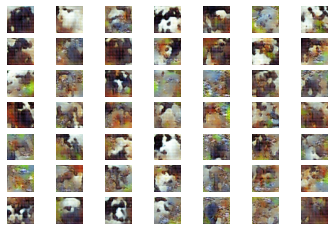

>22, 1/160, d1=0.501, d2=0.574 g=1.204
>22, 2/160, d1=0.607, d2=0.535 g=1.157
>22, 3/160, d1=0.557, d2=0.519 g=1.151
>22, 4/160, d1=0.510, d2=0.605 g=1.200
>22, 5/160, d1=0.488, d2=0.587 g=1.190
>22, 6/160, d1=0.551, d2=0.600 g=1.211
>22, 7/160, d1=0.617, d2=0.605 g=1.072
>22, 8/160, d1=0.611, d2=0.674 g=1.055
>22, 9/160, d1=0.642, d2=0.704 g=1.128
>22, 10/160, d1=0.577, d2=0.534 g=1.135
>22, 11/160, d1=0.676, d2=0.542 g=0.998
>22, 12/160, d1=0.654, d2=0.690 g=1.013
>22, 13/160, d1=0.622, d2=0.653 g=1.121
>22, 14/160, d1=0.666, d2=0.594 g=1.184
>22, 15/160, d1=0.706, d2=0.546 g=1.167
>22, 16/160, d1=0.631, d2=0.550 g=1.126
>22, 17/160, d1=0.565, d2=0.552 g=1.217
>22, 18/160, d1=0.563, d2=0.560 g=1.250
>22, 19/160, d1=0.606, d2=0.676 g=1.334
>22, 20/160, d1=0.708, d2=0.522 g=1.237
>22, 21/160, d1=0.671, d2=0.577 g=1.161
>22, 22/160, d1=0.690, d2=0.577 g=1.152
>22, 23/160, d1=0.577, d2=0.645 g=1.190
>22, 24/160, d1=0.679, d2=0.533 g=1.178
>22, 25/160, d1=0.703, d2=0.611 g=1.130
>22, 26/1

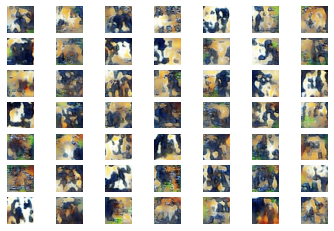

>23, 1/160, d1=0.526, d2=0.544 g=1.171
>23, 2/160, d1=0.678, d2=0.523 g=1.109
>23, 3/160, d1=0.540, d2=0.614 g=1.238
>23, 4/160, d1=0.658, d2=0.540 g=1.189
>23, 5/160, d1=0.644, d2=0.539 g=1.109
>23, 6/160, d1=0.546, d2=0.608 g=0.985
>23, 7/160, d1=0.469, d2=0.664 g=0.976
>23, 8/160, d1=0.583, d2=0.751 g=1.022
>23, 9/160, d1=0.552, d2=0.740 g=0.996
>23, 10/160, d1=0.660, d2=0.719 g=0.961
>23, 11/160, d1=0.679, d2=0.613 g=0.971
>23, 12/160, d1=0.641, d2=0.618 g=0.962
>23, 13/160, d1=0.627, d2=0.670 g=1.019
>23, 14/160, d1=0.666, d2=0.609 g=1.038
>23, 15/160, d1=0.622, d2=0.625 g=1.175
>23, 16/160, d1=0.689, d2=0.554 g=1.333
>23, 17/160, d1=0.594, d2=0.437 g=1.447
>23, 18/160, d1=0.539, d2=0.479 g=1.531
>23, 19/160, d1=0.505, d2=0.570 g=1.476
>23, 20/160, d1=0.472, d2=0.528 g=1.397
>23, 21/160, d1=0.621, d2=0.671 g=1.276
>23, 22/160, d1=0.679, d2=0.666 g=1.384
>23, 23/160, d1=0.754, d2=0.546 g=1.500
>23, 24/160, d1=0.816, d2=0.555 g=1.325
>23, 25/160, d1=0.805, d2=0.685 g=1.171
>23, 26/1

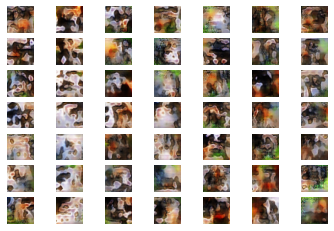

>24, 1/160, d1=0.579, d2=0.649 g=1.090
>24, 2/160, d1=0.693, d2=0.641 g=1.020
>24, 3/160, d1=0.695, d2=0.575 g=1.013
>24, 4/160, d1=0.662, d2=0.593 g=1.036
>24, 5/160, d1=0.717, d2=0.600 g=0.984
>24, 6/160, d1=0.710, d2=0.628 g=1.014
>24, 7/160, d1=0.720, d2=0.642 g=0.998
>24, 8/160, d1=0.735, d2=0.627 g=1.010
>24, 9/160, d1=0.630, d2=0.647 g=1.073
>24, 10/160, d1=0.657, d2=0.566 g=1.086
>24, 11/160, d1=0.721, d2=0.578 g=1.074
>24, 12/160, d1=0.703, d2=0.534 g=1.001
>24, 13/160, d1=0.596, d2=0.627 g=0.993
>24, 14/160, d1=0.537, d2=0.564 g=0.982
>24, 15/160, d1=0.592, d2=0.659 g=0.978
>24, 16/160, d1=0.506, d2=0.735 g=1.011
>24, 17/160, d1=0.520, d2=0.630 g=1.107
>24, 18/160, d1=0.744, d2=0.760 g=1.074
>24, 19/160, d1=0.748, d2=0.658 g=0.992
>24, 20/160, d1=0.794, d2=0.803 g=1.108
>24, 21/160, d1=0.758, d2=0.508 g=1.298
>24, 22/160, d1=0.689, d2=0.461 g=1.264
>24, 23/160, d1=0.602, d2=0.580 g=1.173
>24, 24/160, d1=0.552, d2=0.744 g=1.020
>24, 25/160, d1=0.670, d2=0.767 g=1.026
>24, 26/1

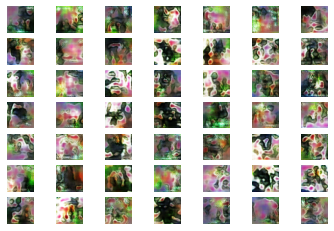

>25, 1/160, d1=0.508, d2=0.439 g=1.213
>25, 2/160, d1=0.628, d2=0.584 g=1.067
>25, 3/160, d1=0.564, d2=0.621 g=1.032
>25, 4/160, d1=0.724, d2=0.708 g=0.994
>25, 5/160, d1=0.637, d2=0.633 g=1.137
>25, 6/160, d1=0.732, d2=0.553 g=1.129
>25, 7/160, d1=0.800, d2=0.560 g=1.054
>25, 8/160, d1=0.747, d2=0.722 g=1.012
>25, 9/160, d1=0.712, d2=0.573 g=0.923
>25, 10/160, d1=0.596, d2=0.636 g=0.966
>25, 11/160, d1=0.701, d2=0.579 g=0.963
>25, 12/160, d1=0.645, d2=0.601 g=0.952
>25, 13/160, d1=0.681, d2=0.631 g=0.933
>25, 14/160, d1=0.665, d2=0.684 g=0.913
>25, 15/160, d1=0.576, d2=0.701 g=0.916
>25, 16/160, d1=0.688, d2=0.817 g=0.956
>25, 17/160, d1=0.700, d2=0.692 g=1.022
>25, 18/160, d1=0.717, d2=0.633 g=1.023
>25, 19/160, d1=0.701, d2=0.629 g=0.989
>25, 20/160, d1=0.644, d2=0.623 g=0.939
>25, 21/160, d1=0.578, d2=0.658 g=0.916
>25, 22/160, d1=0.561, d2=0.638 g=0.955
>25, 23/160, d1=0.680, d2=0.737 g=1.008
>25, 24/160, d1=0.693, d2=0.623 g=1.031
>25, 25/160, d1=0.751, d2=0.604 g=0.998
>25, 26/1

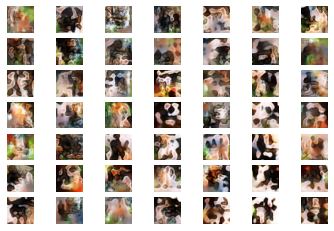

>26, 1/160, d1=0.623, d2=0.615 g=0.977
>26, 2/160, d1=0.722, d2=0.582 g=1.022
>26, 3/160, d1=0.816, d2=0.581 g=0.911
>26, 4/160, d1=0.722, d2=0.739 g=0.910
>26, 5/160, d1=0.705, d2=0.700 g=1.094
>26, 6/160, d1=0.743, d2=0.543 g=1.291
>26, 7/160, d1=0.661, d2=0.490 g=1.349
>26, 8/160, d1=0.659, d2=0.527 g=1.156
>26, 9/160, d1=0.614, d2=0.659 g=1.051
>26, 10/160, d1=0.630, d2=0.700 g=0.978
>26, 11/160, d1=0.655, d2=0.664 g=1.056
>26, 12/160, d1=0.748, d2=0.583 g=1.057
>26, 13/160, d1=0.631, d2=0.627 g=1.086
>26, 14/160, d1=0.719, d2=0.670 g=0.993
>26, 15/160, d1=0.672, d2=0.607 g=0.885
>26, 16/160, d1=0.697, d2=0.684 g=0.920
>26, 17/160, d1=0.692, d2=0.688 g=0.882
>26, 18/160, d1=0.697, d2=0.710 g=0.866
>26, 19/160, d1=0.579, d2=0.655 g=0.916
>26, 20/160, d1=0.666, d2=0.673 g=0.948
>26, 21/160, d1=0.657, d2=0.684 g=1.041
>26, 22/160, d1=0.733, d2=0.534 g=0.985
>26, 23/160, d1=0.708, d2=0.615 g=0.959
>26, 24/160, d1=0.659, d2=0.617 g=0.941
>26, 25/160, d1=0.638, d2=0.647 g=0.921
>26, 26/1

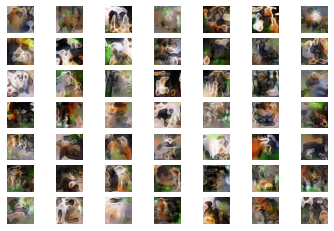

>27, 1/160, d1=0.643, d2=0.688 g=0.836
>27, 2/160, d1=0.598, d2=0.745 g=0.840
>27, 3/160, d1=0.687, d2=0.736 g=0.839
>27, 4/160, d1=0.647, d2=0.673 g=0.872
>27, 5/160, d1=0.670, d2=0.722 g=0.937
>27, 6/160, d1=0.638, d2=0.612 g=1.044
>27, 7/160, d1=0.634, d2=0.611 g=1.014
>27, 8/160, d1=0.659, d2=0.523 g=0.976
>27, 9/160, d1=0.619, d2=0.660 g=0.957
>27, 10/160, d1=0.586, d2=0.707 g=0.956
>27, 11/160, d1=0.752, d2=0.590 g=0.967
>27, 12/160, d1=0.679, d2=0.608 g=0.891
>27, 13/160, d1=0.644, d2=0.641 g=0.905
>27, 14/160, d1=0.655, d2=0.703 g=0.892
>27, 15/160, d1=0.638, d2=0.606 g=0.903
>27, 16/160, d1=0.536, d2=0.666 g=0.937
>27, 17/160, d1=0.686, d2=0.637 g=0.944
>27, 18/160, d1=0.640, d2=0.620 g=0.965
>27, 19/160, d1=0.709, d2=0.603 g=0.964
>27, 20/160, d1=0.711, d2=0.684 g=0.955
>27, 21/160, d1=0.712, d2=0.589 g=0.974
>27, 22/160, d1=0.686, d2=0.582 g=1.029
>27, 23/160, d1=0.639, d2=0.557 g=1.054
>27, 24/160, d1=0.688, d2=0.560 g=1.036
>27, 25/160, d1=0.726, d2=0.594 g=1.018
>27, 26/1

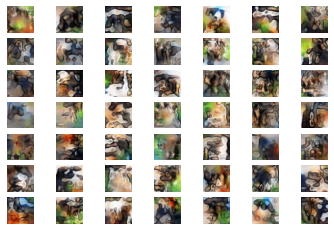

>28, 1/160, d1=0.602, d2=0.624 g=0.919
>28, 2/160, d1=0.671, d2=0.603 g=0.903
>28, 3/160, d1=0.666, d2=0.620 g=0.901
>28, 4/160, d1=0.674, d2=0.628 g=0.927
>28, 5/160, d1=0.664, d2=0.648 g=0.939
>28, 6/160, d1=0.654, d2=0.570 g=0.893
>28, 7/160, d1=0.707, d2=0.709 g=0.891
>28, 8/160, d1=0.690, d2=0.668 g=0.873
>28, 9/160, d1=0.639, d2=0.659 g=0.882
>28, 10/160, d1=0.660, d2=0.671 g=0.928
>28, 11/160, d1=0.679, d2=0.662 g=0.876
>28, 12/160, d1=0.628, d2=0.606 g=0.910
>28, 13/160, d1=0.691, d2=0.615 g=0.953
>28, 14/160, d1=0.643, d2=0.584 g=0.930
>28, 15/160, d1=0.601, d2=0.623 g=0.871
>28, 16/160, d1=0.707, d2=0.739 g=0.859
>28, 17/160, d1=0.616, d2=0.678 g=0.846
>28, 18/160, d1=0.605, d2=0.670 g=0.851
>28, 19/160, d1=0.643, d2=0.667 g=0.916
>28, 20/160, d1=0.643, d2=0.630 g=0.896
>28, 21/160, d1=0.582, d2=0.623 g=0.896
>28, 22/160, d1=0.594, d2=0.611 g=0.902
>28, 23/160, d1=0.561, d2=0.712 g=0.906
>28, 24/160, d1=0.622, d2=0.685 g=0.875
>28, 25/160, d1=0.617, d2=0.667 g=1.015
>28, 26/1

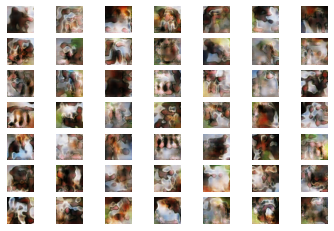

>29, 1/160, d1=0.639, d2=0.748 g=0.848
>29, 2/160, d1=0.580, d2=0.675 g=0.922
>29, 3/160, d1=0.626, d2=0.708 g=0.931
>29, 4/160, d1=0.642, d2=0.614 g=0.941
>29, 5/160, d1=0.558, d2=0.645 g=0.902
>29, 6/160, d1=0.539, d2=0.750 g=1.027
>29, 7/160, d1=0.637, d2=0.688 g=1.009
>29, 8/160, d1=0.748, d2=0.668 g=0.981
>29, 9/160, d1=0.731, d2=0.665 g=1.059
>29, 10/160, d1=0.685, d2=0.502 g=1.078
>29, 11/160, d1=0.662, d2=0.576 g=1.048
>29, 12/160, d1=0.612, d2=0.597 g=1.052
>29, 13/160, d1=0.599, d2=0.631 g=1.068
>29, 14/160, d1=0.663, d2=0.567 g=0.986
>29, 15/160, d1=0.747, d2=0.650 g=0.975
>29, 16/160, d1=0.669, d2=0.587 g=0.898
>29, 17/160, d1=0.733, d2=0.710 g=0.878
>29, 18/160, d1=0.685, d2=0.756 g=0.927
>29, 19/160, d1=0.700, d2=0.629 g=1.000
>29, 20/160, d1=0.754, d2=0.570 g=0.979
>29, 21/160, d1=0.685, d2=0.569 g=0.857
>29, 22/160, d1=0.618, d2=0.648 g=0.869
>29, 23/160, d1=0.627, d2=0.726 g=0.844
>29, 24/160, d1=0.663, d2=0.667 g=0.864
>29, 25/160, d1=0.669, d2=0.659 g=0.866
>29, 26/1

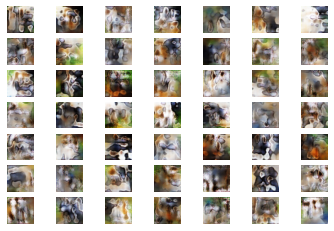

>30, 1/160, d1=0.592, d2=0.634 g=0.913
>30, 2/160, d1=0.608, d2=0.693 g=0.895
>30, 3/160, d1=0.687, d2=0.722 g=0.889
>30, 4/160, d1=0.574, d2=0.660 g=0.895
>30, 5/160, d1=0.675, d2=0.713 g=0.861
>30, 6/160, d1=0.700, d2=0.682 g=0.900
>30, 7/160, d1=0.668, d2=0.692 g=0.920
>30, 8/160, d1=0.676, d2=0.642 g=0.997
>30, 9/160, d1=0.684, d2=0.566 g=0.961
>30, 10/160, d1=0.636, d2=0.704 g=1.058
>30, 11/160, d1=0.698, d2=0.490 g=1.118
>30, 12/160, d1=0.779, d2=0.560 g=1.118
>30, 13/160, d1=0.765, d2=0.581 g=0.997
>30, 14/160, d1=0.685, d2=0.621 g=0.985
>30, 15/160, d1=0.620, d2=0.567 g=1.006
>30, 16/160, d1=0.618, d2=0.605 g=0.953
>30, 17/160, d1=0.694, d2=0.599 g=0.955
>30, 18/160, d1=0.676, d2=0.627 g=0.910
>30, 19/160, d1=0.681, d2=0.674 g=0.918
>30, 20/160, d1=0.638, d2=0.654 g=0.920
>30, 21/160, d1=0.692, d2=0.584 g=0.881
>30, 22/160, d1=0.664, d2=0.664 g=0.839
>30, 23/160, d1=0.677, d2=0.696 g=0.849
>30, 24/160, d1=0.665, d2=0.693 g=0.898
>30, 25/160, d1=0.702, d2=0.649 g=0.921
>30, 26/1

KeyboardInterrupt: 

In [20]:
latent_dim = 100
d_model = define_discriminator()
g_model = define_generator(latent_dim)
gan_model = define_gan(g_model, d_model)
dataset = load_images()
train(g_model, d_model, gan_model, dataset, latent_dim)